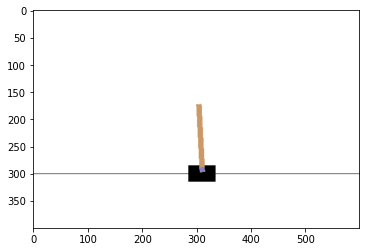

In [ ]:
#DDDQN
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as k
from keras.optimizers import Adam
import numpy as np
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import deque
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

#Building a class for Double Deep Q learning to understand Environment and Agents
%load_ext tensorboard
%tensorboard --logdir logs



class DuelingDoubleDeepQLearning():

  def __init__(self,no_episodes=250,no_complete=50,env_steps=None,gamma=0.9,epsilon=0.9,epsilon_min=0.05,log_epsilon=0.855,alpha=0.01,
               alpha_decay=0.01,batch_size=128,monitor=False,quiet=False):
    self.replay_memory= deque(maxlen=1000)
    self.env=gym.make('CartPole-v0')
    self.gamma=gamma
    self.epsilon=epsilon
    self.epsilon_min=epsilon_min
    self.log_epsilon=log_epsilon
    self.alpha=alpha
    self.alpha_decay=alpha_decay
    self.no_episodes=no_episodes
    self.no_complete=no_complete
    self.batch_size=batch_size
    self.quiet=quiet

    if env_steps is not None:
      self.env._max_episode_steps=env_steps
    
    self.model=Sequential()
    self.model.add(Dense(48,input_dim=4,activation="tanh"))
    self.model.add(Dense(48,activation="tanh"))
    self.model.add(Dense(2,activation="sigmoid"))
    def advantage_loss(y_true,y_pred):
      q_val=y_pred
      v_val=y_true
      advantage=(q_val-v_val)
      adv_mean=k.mean(advantage)
      adv_factor=1/adv_mean*(k.sum(advantage))
      loss=- adv_factor*self.epsilon
      return loss 
    self.model.compile(loss=advantage_loss,optimizer=Adam(lr=self.alpha,decay=self.alpha_decay))
    self.target_model=Sequential()
    self.target_model.add(Dense(48,input_dim=4,activation="tanh"))
    self.target_model.add(Dense(48,activation="tanh"))
    self.target_model.add(Dense(2,activation="sigmoid"))
    self.target_model.compile(loss='mse',optimizer=Adam(lr=self.alpha,decay=self.alpha_decay))
    
  def remember(self,state,action,reward,next_state,done):
    self.replay_memory.append((state,action,reward,next_state,done))
  
  def choose_step(self,state,epsilon):
    return self.env.action_space.sample() if(np.random.random()<=epsilon)  else np.argmax(self.model.predict(state))

  def preprocess_state(self,state):
    return np.reshape(state,[1,4])
  
  def get_epsilon(self,t):
    return max(self.epsilon_min,min(self.epsilon,1.0-math.log((t+1)*self.log_epsilon)))

  def decay_epsilon(self):
    if self.epsilon>self.epsilon_min:
      self.epsilon*=self.log_epsilon
    
  def replay(self,batch_size):
    x_batch,y_batch=[],[]
    minibatch=random.sample(
        self.replay_memory,min(len(self.replay_memory),batch_size))
    for state,action,reward,next_state,done in minibatch:
      y_target=self.model.predict(state)
      y_next_target=self.model.predict(next_state)
      y_next_val=self.target_model.predict(next_state)
      #DQN Update
      #y_target[0][action]=reward if done else reward+self.gamma*(np.max(self.model.predict(next_state)[0]))
      #DDQN Update
      y_next_target[0][action]=reward if done else reward+self.gamma*(np.max(y_next_val[0]))
      x_batch.append(state[0])
      #DQN
      #y_batch.append(y_target[0])
      #DDQN
      y_batch.append(y_next_target[0])
    tensorboard_callback = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=agent.batch_size,
                         write_images=True)

    self.model.fit(np.array(x_batch),np.array(y_batch),batch_size=len(x_batch),verbose=1,callbacks=[tensorboard_callback])
    self.decay_epsilon()

  def run(self):
    print(self.env.action_space)
    total_scores=deque(maxlen=100)
    for i in range(self.no_episodes):
      state= self.preprocess_state(self.env.reset())
      done=False
      j=0
      while not done:
        action= self.choose_step(state,self.get_epsilon(i))
        next_state,reward,done,_=self.env.step(action)
        next_state=self.preprocess_state(next_state)
        self.remember(state,action,reward,next_state,done)
        #self.env.render()
        screen = self.env.render(mode='rgb_array')
        
        state=next_state
        j+=1
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

      total_scores.append(j)
      mean_score=np.mean(total_scores)
      if mean_score >=self.no_complete and i>=100:
        if not self.quiet:
          print("Ran {} episodes.Solving after {} trainings".format(i,i-100))
          return i-100
      if i%100==0 and not self.quiet:
        print("Episode Completed {} .Mean score {}".format(i,mean_score))
      
      self.replay(self.batch_size)
    if not self.quiet:
      print("Not solved after {} episodes",format(i))
    return i



if __name__=="__main__":
  agent=DuelingDoubleDeepQLearning()
  agent.run()
  %tensorboard --logdir logs

    
   
  



In [2]:

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1